<a href="https://colab.research.google.com/github/gabrielborja/python_data_analysis/blob/main/real_state_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Real State Analytics

Real state data from apartments for sale in Quito - Ecuador can be obtained from the following link [here](https://www.properati.com.ec/s/la-carolina/departamento/venta/m2:60-70_habitaciones:1/?sort=published_on_desc)

## Uploading packages and data

In [1]:
#Importing HTTP libraries
import requests
import pprint
from bs4 import BeautifulSoup as bs

In [2]:
#Importing data manipulation libraries
import numpy as np
import pandas as pd
from time import sleep
from random import randint

##Retrieving data from URL

In [ ]:
#class requests.Response
#Response.elapsed, Response.encoding, Response.headers, Response.json, Response.status_code, Response.text, Response.url

In [3]:
#Create a function to retrieve data from given URL
def get_url(url):
  """Retrieve data from given URL and return a dataframe"""
  
  #Get data and parse with BeautifulSoup
  try:
    response = requests.get(url)
    print(response)
    #pprint.pprint(response.text[:200]) #Print first 200 char from HTML.
    soup = bs(response.text, 'html.parser')

    #Save retrieved data to lists
    d1_names = [i.text for i in soup.find_all(class_ ='bwJAej')]
    d1_location = [i.text for i in soup.find_all(class_ = 'fqaBNm')]
    d1_prices = [i.text for i in soup.find_all(class_ ='bZCCaW')]
    d1_rooms = [i.span.text for i in soup.find_all(class_ = 'fgcFIO') if 'habitaci' in i.text]
    d1_bathrooms = [i.text for i in soup.find_all('span') if 'baño' in i.text]
    d1_sqr_meters = [i.text for i in soup.find_all('span') if 'm²' in i.text]
    d1_seller_names = [i.text for i in soup.find_all(class_ = 'seller-name')]
    d1_times = [i['datetime'] for i in soup.find_all('time')]
    
    #Save data to dataframe
    df = pd.DataFrame()
    df = df.assign(date=d1_times, name=d1_names, location=d1_location,
                   price=d1_prices, rooms=d1_rooms, bathrooms=d1_bathrooms,
                   sqr_meters=d1_sqr_meters, seller=d1_seller_names)
    return df

  except requests.exceptions.RequestException as e:
    print(e)

In [4]:
#Scraping apartments from mulitple pages and saving the returned dataframes to a list
data = []
url = 'https://www.properati.com.ec/s/inaquito/departamento/venta/publicados:ultimos-7-dias_m2:23-10000_habitaciones:1,2,3_ba%C3%B1os:1,2,3,4,5-_precio:0-2000000?sort=published_on_desc&page='

for i in range(1, 3):
  page = url + str(i)
  data.append(get_url(page))
  sleep(randint(3,8))


<Response [200]>
<Response [200]>


In [6]:
#Checking one of the returned dataframes inside list
data[1].tail()

,date,name,location,price,rooms,bathrooms,sqr_meters,seller
0,2021-08-23T00:00:00.000Z,Departamento en Bellavista,"Bellavista, Iñaquito, Centro Norte, Quito, Pic...",$ 185.000,3 habitaciones,3 baños,140 m²,CONEXIÓN-INMOBILIARIA


In [7]:
#Concatenating dataframes from list
df1 = pd.concat(objs=[i for i in data], ignore_index=True)
df1.shape #==> from page 1 to the end

(31, 8)

In [8]:
#Exporting to excel into local disk
from google.colab import files
df1.to_excel('2021_08_28_inaquito.xlsx', index=False) #==> Excluding index from file
files.download('2021_08_28_inaquito.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Data Cleaning

In [9]:
#Importing data manipulation libraries
import numpy as np
import pandas as pd

In [ ]:
#Removing previous versions of the uploaded file
!rm 2021_08_28_inaquito.xlsx

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded1 = files.upload()

In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df1 = pd.read_excel(io.BytesIO(uploaded1['2021_07_21_inaquito.xlsx']), parse_dates=True)

In [10]:
#Checking the dataframe information
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        31 non-null     object
 1   name        31 non-null     object
 2   location    31 non-null     object
 3   price       31 non-null     object
 4   rooms       31 non-null     object
 5   bathrooms   31 non-null     object
 6   sqr_meters  31 non-null     object
 7   seller      31 non-null     object
dtypes: object(8)
memory usage: 2.1+ KB


In [ ]:
#Checking the dataframe tail
df1.tail()

In [11]:
#Converting date column to datetime with naive timezone
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)#.dt.tz_convert('America/Guayaquil')

In [12]:
#Checking data type after datetime conversion
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        31 non-null     datetime64[ns]
 1   name        31 non-null     object        
 2   location    31 non-null     object        
 3   price       31 non-null     object        
 4   rooms       31 non-null     object        
 5   bathrooms   31 non-null     object        
 6   sqr_meters  31 non-null     object        
 7   seller      31 non-null     object        
dtypes: datetime64[ns](1), object(7)
memory usage: 2.1+ KB


In [13]:
#Extracting city and zone from location
df1['city'] = [i[3].strip() for i in df1['location'].str.split(',')]
df1['zone'] = [i[0].strip() for i in df1['location'].str.split(',')]

In [14]:
#Eliminating $ and . from price and convert to int
df1['price'] = df1['price'].str.replace('\$*\.*', '', regex=True)
df1['price'] = df1['price'].astype(int)

In [15]:
#Converting number of rooms to int
df1['rooms'] = [i[0].strip() for i in df1['rooms'].str.split(' ')]
df1['rooms'] = df1['rooms'].astype(int)

In [16]:
#Converting bathrooms to int
df1['bathrooms'] = [i[0].strip() for i in df1['bathrooms'].str.split(' ')]
df1['bathrooms'] = df1['bathrooms'].astype(int)

In [17]:
#Converting square meters to int
df1['sqr_meters'] = [i[0].strip() for i in df1['sqr_meters'].str.split(' ')]
df1['sqr_meters'] = df1['sqr_meters'].astype(int)

In [18]:
#Checking unique values for square meters
df1['sqr_meters'].unique()

array([112, 185, 100,  97,  62,  58,  72,  98,  47,  90,  48, 223, 139,
        77, 130, 156,  89, 105, 155, 124, 200, 102, 388,  55, 160, 420,
       140])

In [19]:
#Converting sellers to title case
df1['seller'] = df1['seller'].str.title()

In [20]:
#Rearranging order of columns
df1 = df1[['date', 'city', 'zone', 'name', 'seller', 'sqr_meters', 'rooms', 'bathrooms', 'price']]

In [21]:
#Checking the dataframe tail
df1.tail(3)

,date,city,zone,name,seller,sqr_meters,rooms,bathrooms,price
28,2021-08-23,Quito,Bellavista,Departamento en Bellavista,Monica Villalba,420,3,4,650000
29,2021-08-23,Quito,Bellavista,Departamento en Bellavista,Conexión-Inmobiliaria,140,3,3,185000
30,2021-08-23,Quito,Bellavista,Departamento en Bellavista,Conexión-Inmobiliaria,140,3,3,185000


In [22]:
#Checking the final version of the dataframe after cleaning
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        31 non-null     datetime64[ns]
 1   city        31 non-null     object        
 2   zone        31 non-null     object        
 3   name        31 non-null     object        
 4   seller      31 non-null     object        
 5   sqr_meters  31 non-null     int64         
 6   rooms       31 non-null     int64         
 7   bathrooms   31 non-null     int64         
 8   price       31 non-null     int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 2.3+ KB


In [23]:
#Exporting to csv into local disk
from google.colab import files
df1.to_csv('2021_08_28_inaquito.csv', index=False) #==> Excluding index from file
files.download('2021_08_28_inaquito.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Apartments EDA

In [ ]:
#Plotly --upgrade
!pip install plotly --upgrade

In [ ]:
#Removing previous versions of the file
!rm 2021_07_17_la_carolina.csv

In [ ]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import seaborn as sns
import plotly.express as px

In [ ]:
#Customizing data visualization style
sns.set_theme(rc = {'figure.figsize': (8, 4)})

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded1 = files.upload()

In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df1 = pd.read_csv(io.BytesIO(uploaded1['2021_07_21_casas_quito.csv']), parse_dates=True)

In [ ]:
#Checking the dataframe info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        253 non-null    object
 1   city        253 non-null    object
 2   zone        253 non-null    object
 3   name        253 non-null    object
 4   seller      253 non-null    object
 5   sqr_meters  253 non-null    int64 
 6   rooms       253 non-null    int64 
 7   bathrooms   253 non-null    int64 
 8   price       253 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 17.9+ KB


In [ ]:
#Converting date column to datetime
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
#Selecting essential columns and saving to new dataframe
df1_apa = df1.drop(columns='seller').copy()
df1_apa.tail()

,date,city,zone,name,sqr_meters,rooms,bathrooms,price
248,2020-10-28 19:00:00-05:00,Quito,Gonzalez Suarez,Casa en Gonzalez Suarez,1400,5,6,380000
249,2020-10-28 19:00:00-05:00,Quito,El Batan,Casa en El Batan,441,7,6,340000
250,2020-10-28 19:00:00-05:00,Pichincha,Iñaquito,Casa en Iñaquito,110,3,2,72800
251,2020-10-28 19:00:00-05:00,Quito,El Batan,Casa en El Batan,80,2,2,65000
252,2020-10-28 19:00:00-05:00,Pichincha,Iñaquito,Casa en Iñaquito,2690,4,4,650000


In [ ]:
#Assigning columns as categorical data
df1_apa['rooms'] = df1_apa['rooms'].astype("category")
df1_apa['bathrooms'] = df1_apa['bathrooms'].astype("category")

In [ ]:
#Performing descriptive statistics
df1_apa.describe()

,sqr_meters,price
count,253.000000,2.530000e+02
mean,499.818182,3.128092e+05
std,710.781678,2.482796e+05
min,54.000000,4.850000e+04
25%,180.000000,1.230000e+05
50%,330.000000,2.590000e+05
75%,562.000000,4.200000e+05
max,8400.000000,1.950000e+06


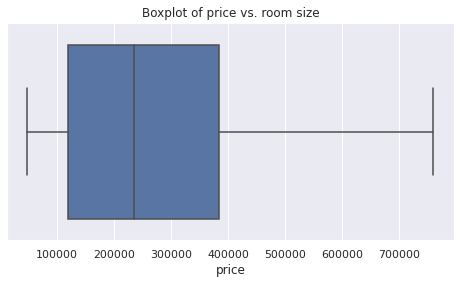

In [ ]:
#Plotting the boxplot of price
sns.boxplot(x='price', data=df1_apa)
plt.title('Boxplot of price vs. room size')
plt.show()

In [ ]:
#Calculating outlier threshold
iqr = (df1_apa['price'].quantile(0.75) - df1_apa['price'].quantile(0.25))
outl = (df1_apa['price'].quantile(0.75) + 1.5*iqr) #==> Third quartile + 1.5*IQR
print(iqr, outl)

297000.0 865500.0


In [ ]:
#Dropping outliers from dataset
df1_apa = df1_apa[df1_apa['price']<outl].reset_index(drop=True)
df1_apa.shape

(249, 8)

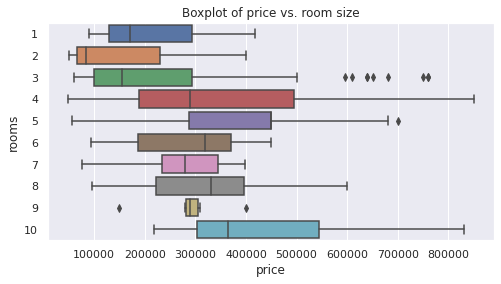

In [ ]:
#Plotting the box plot of price for different room sizes
sns.boxplot(x='price', y='rooms', data=df1_apa) #palette=['#ffff00', '#0000ff', '#ff0000'])
plt.title('Boxplot of price vs. room size')
plt.show()

In [ ]:
#Plotting pairplot of price vs square meters
sns.pairplot(data=df1_apa, height=3, aspect=1.5)
plt.show()

In [ ]:
df1_apa['date'] = df1_apa['date'].astype(st)

In [ ]:
#Exporting to excel into local disk
from google.colab import files
df1_apa.to_excel('2021_07_21_casas_quito.xlsx', index=False) #==> Excluding index from file
files.download('2021_07_21_casas_quito.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Grouping by year, month and rooms
df1_grouped = df1_apa.copy()
df1_grouped = df1_grouped.assign(price_sqr = round((df1_grouped['price']/df1_grouped['sqr_meters']), 2),
                                 year = df1_grouped['date'].dt.year,
                                 month = df1_grouped['date'].dt.month)
df1_grouped = df1_grouped.groupby(['year', 'month', 'rooms']).agg(price = ('price', 'mean'), price_sqr = ('price_sqr', 'mean')).reset_index()
df1_grouped.tail()

,year,month,rooms,price,price_sqr
195,2021,12,6,NaN,NaN
196,2021,12,7,NaN,NaN
197,2021,12,8,NaN,NaN
198,2021,12,9,NaN,NaN
199,2021,12,10,NaN,NaN


In [ ]:
#Plotting square meters vs price
@interact(rooms=[1,2,3])
def plot_scatter(rooms):
  sns.regplot(x='sqr_meters', y='price', data=df1_apa[df1_apa['rooms']==rooms], seed=1)
  plt.title(f'Scatterplot of {rooms} rooms Apartments')
  plt.show()

interactive(children=(Dropdown(description='rooms', options=(1, 2, 3, 4, 5, 6, 7), value=1), Output()), _dom_c…

In [ ]:
#Plot the price vs time for different categories
@interact(year=[2020, 2021], rooms=df1_apa['rooms'].unique())
def plot_scatter(year, rooms):
  fig1_a = px.bar(data_frame=df1_grouped[(df1_grouped['year']==year) & (df1_grouped['rooms']==rooms)], x='month', y='price',
                  title='Apartments in Quito', width=900, height=400)
  fig1_a.show()

interactive(children=(Dropdown(description='year', options=(2020, 2021), value=2020), Dropdown(description='ro…

##Machine Learning modeling

###Uploading data

In [ ]:
#Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Customizing data visualization style
sns.set_theme(rc = {'figure.figsize': (12, 4)})

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded1 = files.upload()

Saving 2021_07_19_apartments.csv to 2021_07_19_apartments.csv


In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df1_ml = pd.read_csv(io.BytesIO(uploaded1['2021_07_19_apartments.csv']), parse_dates=True)

In [ ]:
#Dropping date column, assigning categorical type
df1_ml = df1_ml.drop(columns='date')
df1_ml['rooms'] = df1_ml['rooms'].astype("category")
df1_ml['bathrooms'] = df1_ml['bathrooms'].astype("category")
df1_ml.tail()

,sqr_meters,rooms,bathrooms,price
319,121,3,3,155000
320,76,3,2,99000
321,86,2,3,146000
322,113,3,3,221426
323,117,3,3,179530


###Linear Regression

In [ ]:
#Importing machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [ ]:
#Splitting the dataset into train and test
X = np.c_[df1_ml['sqr_meters'].to_numpy(), df1_ml['rooms'].to_numpy(), df1_ml['bathrooms'].to_numpy()]
X_train, X_test, y_train, y_test = train_test_split(X, np.array(df1_ml['price']), random_state=1)
print(X_train.shape, X_test.shape)

#lr = LinearRegression().fit(X_train, y_train)
#print(f'lr.coef_: {lr.coef_}, lr.intercept_: {lr.intercept_}')

(243, 3) (81, 3)


In [ ]:
#Preprocessing using 0-1 scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled[:5])
print(X_test_scaled[:5])

[[0.22 0.   0.  ]
 [0.42 0.   0.  ]
 [0.56 0.5  1.  ]
 [0.45 0.   0.5 ]
 [0.24 0.   0.5 ]]
[[0.13 0.   0.5 ]
 [0.48 0.5  0.5 ]
 [0.1  0.   0.5 ]
 [0.19 0.   0.  ]
 [0.13 0.   0.5 ]]


In [ ]:
#Performing Liner Regression on apartment prices
lr = LinearRegression().fit(X_train_scaled, y_train)
print(f'lr.coef_: {lr.coef_}, lr.intercept_: {lr.intercept_}')

lr.coef_: [56743.49336176  -358.5767255  49152.81300228], lr.intercept_: 90740.25334670303


In [ ]:
#Looking at the training set and test set performance
print(f'Training set score: {lr.score(X_train_scaled, y_train)}')
print(f'Training test score: {lr.score(X_test_scaled, y_test)}')

Training set score: 0.44162440822932986
Training test score: 0.3396124340805059
